## A/B Testing


## Table of Contents
- [Introduction](#intro)
- [Part I - Ckecking-up](#check)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website (MamaZone.com).  My goal is to work through this notebook to help the company understand if they should implement a new page, keep the old page, or perhaps run the experiment longer to make their decision.

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

<a id='check'></a>
#### Part I - Checking-up

***Reading the dataset:***

In [2]:
df = pd.read_csv(r'ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
#Duration of the experiment:
(df['timestamp'].astype('datetime64').max() - df['timestamp'].astype('datetime64')
 .min()) / np.timedelta64(1, 'D')

21.999873633414353

The duration of launching both the old page and the new page to different groups is 22 days

In [3]:
df.shape[0]

294478

***The number of unique users in the dataset:***

In [4]:
df['user_id'].nunique()

290584

***The proportion of users converted:***

In [5]:
df[df['converted'] == 1].shape[0] / df['user_id'].nunique()

0.12126269856564711

***The number of times the `new_page` and `treatment` don't line up***

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

***Missing values:***

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

Now I will create a new dataset that meets some specifications

In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

***Unique user_id***

In [10]:
df2['user_id'].nunique()

290584

In [11]:
df2.loc[df2['user_id'].duplicated(), 'user_id']

2893    773192
Name: user_id, dtype: int64

In [12]:
df2.loc[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2.drop_duplicates(subset='user_id', inplace=True)
df2.shape[0]


290584


***The probability of an individual converting regardless of the page they receive?***

In [14]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

***Given that an individual was in the `control` group, what is the probability they converted?***

In [15]:
control_converted = df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0] / df2[df2['group'] == 'control'].shape[0]
control_converted

0.1203863045004612

***Given that an individual was in the `treatment` group, what is the probability they converted?***

In [16]:
treatment_converted = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)].shape[0] / df2[df2['group'] == 'treatment'].shape[0]
treatment_converted

0.11880806551510564

***The probability that an individual received the new page?***

In [17]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

In [18]:
df2[df2['group'] == 'control'].shape[0] , df2[df2['group'] == 'treatment'].shape[0]

(145274, 145310)

**The number of individuals in the treatment group is slightly higher that the number of individuals in the control group (almost an equal probaility of receiving and not receiving the new_page). However, the conversion rate in the treatment group is a bit lower than the conversion rate in the control group (11.88 % against 12,03 % for the old page viewers). This is not a conclusive evidence to judge whether the new page or the old page generates more conversions. A hypothesis testing through performing an A/B test is necessary to infer which page is better in terms of conversion rate (but with consideration of other practical factors). That is to see if this difference in converted rates is significant and not just due to chance.** 

<a id='ab_test'></a>
### Part II - A/B Test


If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? 

## H0: *P*new - *P*old =< 0 <br>
## H1: *P*new - *P*old > 0

I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then, I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

***What is the convert rate for $p_{new}$ under the null?*** 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

***What is the convert rate for $p_{old}$ under the null?*** <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [21]:
p_new - p_old

0.0

We assumed the null is true and there is no change in the conversion rates between the old and new page. With this assumption, we know how our distribution would look like and from here we will try to look for statistical evidence to accept this hypothesis (fails to reject it) or to reject it.   

In [22]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

In [23]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null

In [24]:
new_page_converted = np.random.choice([1, 0], n_new, p=[p_new, 1-p_new], replace=True)
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null

In [25]:
old_page_converted = np.random.choice([1, 0], n_old, p=[p_old, 1-p_old], replace=True)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

$p_{new}$ - $p_{old}$ for the simulated values

In [26]:
diffs = new_page_converted.mean() - old_page_converted.mean()
diffs

-0.0018605393338880089

***Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one above***

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], n_new, p=[p_new, 1-p_new], replace=True)
    old_page_converted = np.random.choice([1, 0], n_old, p=[p_old, 1-p_old], replace=True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [28]:
p_diffs = np.array(p_diffs)

Histogram of the **p_diffs**:

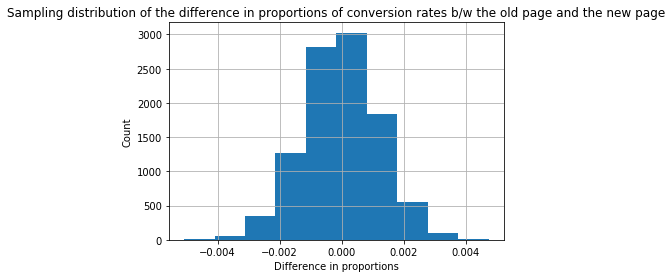

In [29]:
plt.hist(p_diffs);
plt.grid()
plt.title('Sampling distribution of the difference in proportions of conversion rates b/w the old page and the new page')
plt.xlabel('Difference in proportions')
plt.ylabel('Count');

This graph represents the sampling distribution under the null hypothesis.

***What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?***

In [30]:
#The actual difference observed in our dataset:
obs_diffs = treatment_converted - control_converted
obs_diffs

-0.0015782389853555567

In [45]:
#The poroportions of the difference between convertion rates under the null hypothesis (p_diff) 
#that are greater than the actual difference:
p_value = (p_diffs > obs_diffs).mean()
p_value

0.9037

**The computed p-value is 0.90, that is we have a probability of 90% to obtain the observed statistic or 1 more extreme in favor of the alternative given that the null hypothesis is true. Since this p-value is greater than the type I error threshold (5%) we have weak evidence against the null hypothesis (we fail to reject the null). Therefore, we don't have enough evidence that the new web page leeds to more conversions than the old one.**

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Now let's calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2[df2['landing_page'] == 'old_page' ].shape[0] 
n_new = df2[df2['landing_page'] == 'new_page' ].shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

 ***`stats.proportions_ztest` to compute your the test statistic and p-value***

In [33]:
# Our alternative hypothesis is P new > P old, that is convert_new > convert_old
z_stat, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_stat, p_value

(-1.3109241984234394, 0.9050583127590245)

**My findings in this part are consistent with what I found earlier.
The z-statistic associated with a significant alpha level (5%) is 1.96 on the right and -1.96 from the left as shown in z-table <a href ="http://www.z-table.com/">here</a>. Our Z-stat (-1.31) doesn't fall in the rejection region corresponding to the 5% thresholds, and the p-value is 0.905. Therefore, we don't reject the null hypothesis (P-new - P-old =<0) and we can say that there is no significant difference between the old page and the new page in generating conversion rates. The previous method and this method have basically the same result.**

<a id='regression'></a>
### Part III - A regression approach

**Logistic regression**

In [34]:
#The dummy variables:
df2['intercept'] = 1
dummy_var = pd.get_dummies(df2.group)
df2 = df2.join(dummy_var)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [35]:
#Creating one column for the dummy variables (1 if treatment and 0 if control):
df2.rename(columns={'treatment' : 'ab_page'}, inplace=True)
df2.drop('control', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


***Fitting the regression model***

In [36]:
mod = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
res = mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


***Summary of the model***

In [37]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:33:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973


**The p-value associated with ab_page in this logistic model is 0.19. It is quite different from the p-value calculated in the preceding tests (Part II). In fact, the null and alternative hypothesis in this logistic regression are respectively as follows: There is no relationship between receiving the treatment and the convertion rate (H0); There is a relationship between receiving the treatment and the convertion rate (H1). These hypothses asnwer the question of how our response variable (conversion rate) varies on the basis of the group (or landing page). However, in Part II, the hypothesis testing compared which of the web site versions is better (proportion) in conversion rates, that is the probability of a user to convert depdending of the web page he/she receives.**   

Adding additional variables may be very useful in order to predict accurately our dependant variable and to have a thorough understanding of our business. In our case, the tests that we conducted have not confirmed the strong relationship between the response variable (conversion) and the different explanatory variables. Maybe, we can consider other potentially predictive variables like the location of the different individuals in our groups, the duration of viewing the page, or the age of users. However, we must pay attention to the possible difficulties of adding multiple variables in our model, like the multicolinearity problem

***Does the location have any impact on conversion?*** 

In [38]:
countries_df = pd.read_csv(r'H:\NAND\project_3\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [39]:
# Unique 'countries':
set(df_new.country)

{'CA', 'UK', 'US'}

In [40]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [41]:
### Fit Your Linear Model And Obtain the results:
mod2= sm.Logit(df_new['converted'], df_new[['ab_page', 'CA', 'UK', 'intercept']])
res2 = mod2.fit()
print(res2.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:33:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.

***Interaction between page and country to see if there e arsignificant effects on conversion***

In [42]:
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

**The main conclusions from this logistic model are as follows:**<br>
- After introducing the new country dummy variables in our model, the effect of the ab_page didn't realy change. The negative -0.0149 coefficient means that for every 1 unit decrease in the ab_page (in other words, going from treatment to control) the  conversion is 1 time as likely holding all other variables constant.  However, this result is statistically not significant as the p-value associated to this variable is large.
- The coefficient related to the dummy variables aren't statistically significant (p-value > 0.05)<br>
- If a user lives in the United States, he is 1.04 times (4%) more likely to convert than if he lives in Canada, while holding all other variables constant<br>
- If a user lives in the UK, he is 1.001 times  likely to convert than if he lives in the US, while holding all other variables constant.<br>

**Considering these coefficients and the corresponding p-values it doesn't seem that the residence of users has any significant effect on the conversion. Even when comparing the likelihood of conversion between UK and Canada users and the baseline country (US), the difference is very small.**

*Interaction between page and country:*

In [43]:
#Creating the interaction columns:
df_new['page_ca'] = df_new['ab_page'] * df_new['CA']
df_new['page_uk'] = df_new['ab_page'] * df_new['UK']
df_new['page_us'] = df_new['ab_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_ca,page_uk,page_us
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [44]:
mod3 = sm.Logit(df_new['converted'], df_new[['ab_page', 'CA', 'UK', 'page_ca', 'page_uk', 'intercept']])
res3 = mod3.fit()
print(res3.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:33:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.

**The intercation terms allow us to see the way the variable ab_page (treatment or not) is related to the conversion rate depending on the country of users. In this case, the interaction terms are not statistically significant (large p-value), so I can't confirm the effect on conversion.**

<a id='conclusions'></a>
## Conclusions

After all the tests, I can say that the new page will not be very rewarding to the company. Maybe, the experiment should have taken more time instead of only 22 days.
